In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [2]:
import yfinance as yf

In [3]:
#Download Tata motors data from yahoo finance
df = yf.download('INFY.NS')

[*********************100%***********************]  1 of 1 completed


In [4]:
#first 5 samples
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,0.794921,0.796679,0.791015,0.796679,0.519068,204800
1996-01-02,0.794921,0.798828,0.793457,0.793457,0.516968,204800
1996-01-03,0.798828,0.798828,0.798828,0.798828,0.520468,102400
1996-01-04,0.791015,0.794921,0.791015,0.793554,0.517032,307200
1996-01-05,0.784179,0.784179,0.784179,0.784179,0.510924,51200


In [5]:
# to check dates in index
df.index

DatetimeIndex(['1996-01-01', '1996-01-02', '1996-01-03', '1996-01-04',
               '1996-01-05', '1996-01-08', '1996-01-09', '1996-01-10',
               '1996-01-11', '1996-01-12',
               ...
               '2023-06-15', '2023-06-16', '2023-06-19', '2023-06-20',
               '2023-06-21', '2023-06-22', '2023-06-23', '2023-06-26',
               '2023-06-27', '2023-06-30'],
              dtype='datetime64[ns]', name='Date', length=6914, freq=None)

In [6]:
df.shape

(6914, 6)

In [7]:
# to check features or columns 
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [8]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-22,1289.400024,1289.400024,1273.500000,1281.550049,1281.550049,6676607
2023-06-23,1276.449951,1279.349976,1263.349976,1265.000000,1265.000000,7239467
2023-06-26,1270.250000,1274.000000,1262.250000,1270.349976,1270.349976,3403244
2023-06-27,1280.000000,1282.000000,1274.199951,1279.150024,1279.150024,3240024
2023-06-30,1308.199951,1338.900024,1304.449951,1335.500000,1335.500000,12818762


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6914 entries, 1996-01-01 to 2023-06-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6914 non-null   float64
 1   High       6914 non-null   float64
 2   Low        6914 non-null   float64
 3   Close      6914 non-null   float64
 4   Adj Close  6914 non-null   float64
 5   Volume     6914 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 378.1 KB


In [10]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

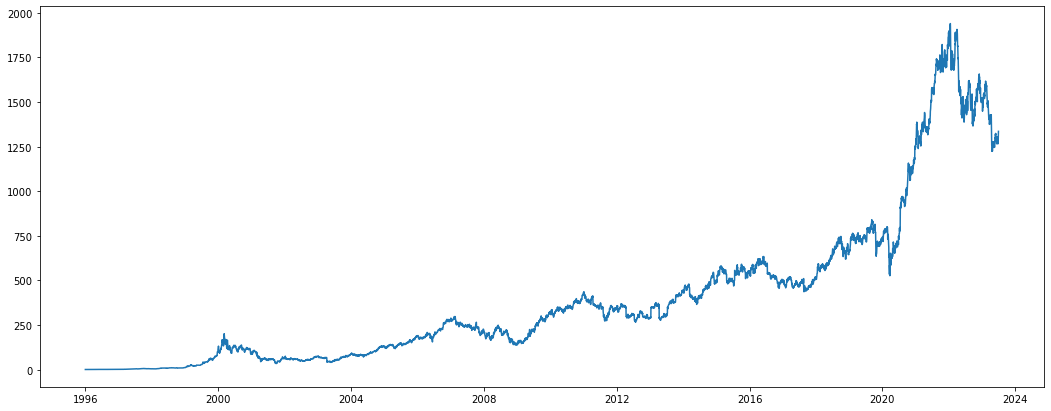

In [12]:
# plot a graph
plt1 = plt.figure(figsize=(18,7))
import matplotlib.pyplot as plt
plt.plot(df['Close'])

In [13]:
# check open price for first day and close price for last day
print("Starting price: ",df.iloc[0][0])
print("Ending price: ", df.iloc[-1][3])

Starting price:  0.7949209809303284
Ending price:  1335.5


In [14]:
# check start date and end date in our dataset
print("Starting date: ",df.index[0])
print("Ending date: ", df.index[-1])

Starting date:  1996-01-01 00:00:00
Ending date:  2023-06-30 00:00:00


In [15]:
# drop some columns except 'close ' columns as we are going to do prediction only on closing price
df.drop(columns=['High','Low','Adj Close','Volume'],inplace=True)

In [16]:
df.head()

,Open,Close
Date,,
1996-01-01,0.794921,0.796679
1996-01-02,0.794921,0.793457
1996-01-03,0.798828,0.798828
1996-01-04,0.791015,0.793554
1996-01-05,0.784179,0.784179


In [17]:
# LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
# Preprocess the data
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df['Close']).reshape(-1,1))

In [18]:
df1

array([[1.72772405e-05],
       [1.56153087e-05],
       [1.83856869e-05],
       ...,
       [6.54852573e-01],
       [6.59391636e-01],
       [6.88456940e-01]])

In [19]:
# Split data into training and testing sets
train_size=int(len(df1)*0.7)
test_size=len(df1)-train_size
train_data,test_data=df1[0:train_size,:],df1[train_size:len(df1),:1]

In [20]:
train_size,test_size

(4839, 2075)

In [21]:
train_data

array([[1.72772405e-05],
       [1.56153087e-05],
       [1.83856869e-05],
       ...,
       [2.76268451e-01],
       [2.75804218e-01],
       [2.75153046e-01]])

In [22]:
# convert an array of values into a dataset matrix
#function to create new dataset which is required by LSTM.giving sequence of data to our LSTM model
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), numpy.array(dataY)

In [23]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
import numpy
time_step = 20
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [24]:
X_train

array([[1.72772405e-05, 1.56153087e-05, 1.83856869e-05, ...,
        3.77770735e-06, 2.26694415e-06, 2.26694415e-06],
       [1.56153087e-05, 1.83856869e-05, 1.56653601e-05, ...,
        2.26694415e-06, 2.26694415e-06, 0.00000000e+00],
       [1.83856869e-05, 1.56653601e-05, 1.08297188e-05, ...,
        2.26694415e-06, 0.00000000e+00, 4.78506729e-06],
       ...,
       [2.53167066e-01, 2.53966565e-01, 2.54205119e-01, ...,
        2.82838444e-01, 2.85236926e-01, 2.75107901e-01],
       [2.53966565e-01, 2.54205119e-01, 2.59208367e-01, ...,
        2.85236926e-01, 2.75107901e-01, 2.76145955e-01],
       [2.54205119e-01, 2.59208367e-01, 2.56977543e-01, ...,
        2.75107901e-01, 2.76145955e-01, 2.76268451e-01]])

In [25]:
y_train

array([0.00000000e+00, 4.78506729e-06, 9.31895559e-06, ...,
       2.76145955e-01, 2.76268451e-01, 2.75804218e-01])

In [26]:
X_test

array([[0.27309627, 0.27592675, 0.28249674, ..., 0.29177468, 0.29512093,
        0.29591399],
       [0.27592675, 0.28249674, 0.2872292 , ..., 0.29512093, 0.29591399,
        0.29292232],
       [0.28249674, 0.2872292 , 0.28960186, ..., 0.29591399, 0.29292232,
        0.28943425],
       ...,
       [0.67914673, 0.67757358, 0.68244786, ..., 0.67189978, 0.66981077,
        0.66062957],
       [0.67757358, 0.68244786, 0.67958521, ..., 0.66981077, 0.66062957,
        0.65209306],
       [0.68244786, 0.67958521, 0.68020414, ..., 0.66062957, 0.65209306,
        0.65485257]])

In [27]:
print(X_train.shape) 

(4818, 20)


In [28]:
print(y_train.shape)

(4818,)


In [29]:
print(X_test.shape)

(2054, 20)


In [30]:
print(ytest.shape)

(2054,)


In [31]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [32]:
X_train.shape

(4818, 20, 1)

In [33]:
X_train

array([[[1.72772405e-05],
        [1.56153087e-05],
        [1.83856869e-05],
        ...,
        [3.77770735e-06],
        [2.26694415e-06],
        [2.26694415e-06]],

       [[1.56153087e-05],
        [1.83856869e-05],
        [1.56653601e-05],
        ...,
        [2.26694415e-06],
        [2.26694415e-06],
        [0.00000000e+00]],

       [[1.83856869e-05],
        [1.56653601e-05],
        [1.08297188e-05],
        ...,
        [2.26694415e-06],
        [0.00000000e+00],
        [4.78506729e-06]],

       ...,

       [[2.53167066e-01],
        [2.53966565e-01],
        [2.54205119e-01],
        ...,
        [2.82838444e-01],
        [2.85236926e-01],
        [2.75107901e-01]],

       [[2.53966565e-01],
        [2.54205119e-01],
        [2.59208367e-01],
        ...,
        [2.85236926e-01],
        [2.75107901e-01],
        [2.76145955e-01]],

       [[2.54205119e-01],
        [2.59208367e-01],
        [2.56977543e-01],
        ...,
        [2.75107901e-01],
        [2.7614

In [34]:
### Create the Stacked LSTM model
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model

In [35]:
#model=Sequential()
#model.add(LSTM(100, input_shape = (time_step , 1)))
#model.add(Dropout(0.2))
#model.add(LSTM(200, input_shape=(time_step , 1), return_sequences=False))
#model.add(Dropout(0.5))
#model.add(Dense(100,kernel_initializer='uniform',activation='sigmoid'))        
#model.add(Dense(1,kernel_initializer='uniform',activation='sigmoid'))
#model.compile(loss='mse',optimizer='adam')

model=Sequential()
model.add(LSTM(50,input_shape=(time_step,1)))
model.add(Dropout(0.2))
#model.add(LSTM(50,return_sequences=True))
#model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
151/151 [==============================] - 8s 25ms/step - loss: 6.8790e-04 - val_loss: 4.1623e-04
Epoch 2/100
151/151 [==============================] - 3s 19ms/step - loss: 1.0642e-04 - val_loss: 2.7153e-04
Epoch 3/100
151/151 [==============================] - 3s 20ms/step - loss: 9.5289e-05 - val_loss: 3.4402e-04
Epoch 4/100
151/151 [==============================] - 3s 20ms/step - loss: 8.1166e-05 - val_loss: 3.7849e-04
Epoch 5/100
151/151 [==============================] - 3s 19ms/step - loss: 7.4878e-05 - val_loss: 0.0016
Epoch 6/100
151/151 [==============================] - 3s 20ms/step - loss: 6.5758e-05 - val_loss: 0.0011
Epoch 7/100
151/151 [==============================] - 3s 18ms/step - loss: 6.3421e-05 - val_loss: 4.6116e-04
Epoch 8/100
151/151 [==============================] - 3s 19ms/step - loss: 5.9449e-05 - val_loss: 2.2609e-04
Epoch 9/100
151/151 [==============================] - 3s 18ms/step - loss: 5.0666e-05 - val_loss: 3.5286e-04
Epoch 10/100
151/1

Epoch 75/100
151/151 [==============================] - 3s 19ms/step - loss: 3.4901e-05 - val_loss: 1.8018e-04
Epoch 76/100
151/151 [==============================] - 3s 19ms/step - loss: 3.6826e-05 - val_loss: 4.5323e-04
Epoch 77/100
151/151 [==============================] - 3s 19ms/step - loss: 3.9268e-05 - val_loss: 1.0832e-04
Epoch 78/100
151/151 [==============================] - 3s 19ms/step - loss: 3.4752e-05 - val_loss: 2.4122e-04
Epoch 79/100
151/151 [==============================] - 3s 19ms/step - loss: 3.6112e-05 - val_loss: 9.0780e-05
Epoch 80/100
151/151 [==============================] - 3s 19ms/step - loss: 3.6950e-05 - val_loss: 9.8388e-05
Epoch 81/100
151/151 [==============================] - 3s 19ms/step - loss: 3.4471e-05 - val_loss: 1.6591e-04
Epoch 82/100
151/151 [==============================] - 3s 19ms/step - loss: 3.7853e-05 - val_loss: 8.0890e-05
Epoch 83/100
151/151 [==============================] - 3s 19ms/step - loss: 3.4654e-05 - val_loss: 1.3566e-04
E

In [38]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

65/65 [==============================] - 1s 7ms/step


In [39]:
train_predict

array([[-0.00037301],
       [-0.0003747 ],
       [-0.00037195],
       ...,
       [ 0.27751127],
       [ 0.2754517 ],
       [ 0.27509066]], dtype=float32)

In [40]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [41]:
train_predict

array([[4.0008344e-02],
       [3.6729395e-02],
       [4.2073939e-02],
       ...,
       [5.3878448e+02],
       [5.3479150e+02],
       [5.3409161e+02]], dtype=float32)

In [42]:
test_predict

array([[ 572.28735],
       [ 568.82886],
       [ 562.2681 ],
       ...,
       [1277.7408 ],
       [1259.8849 ],
       [1259.7994 ]], dtype=float32)

In [43]:
ytest

array([0.29292232, 0.28943425, 0.28201318, ..., 0.65209306, 0.65485257,
       0.65939164])

In [44]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))


221.4158817935137

In [45]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

1001.0618887177188

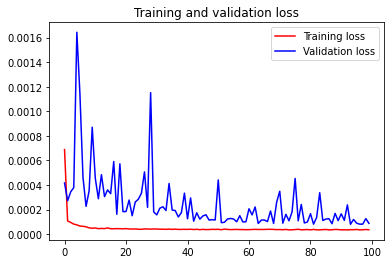

<Figure size 432x288 with 0 Axes>

In [46]:
### plot a graph for training and validation loss to visualize the results of model training

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.figure()


plt.show()

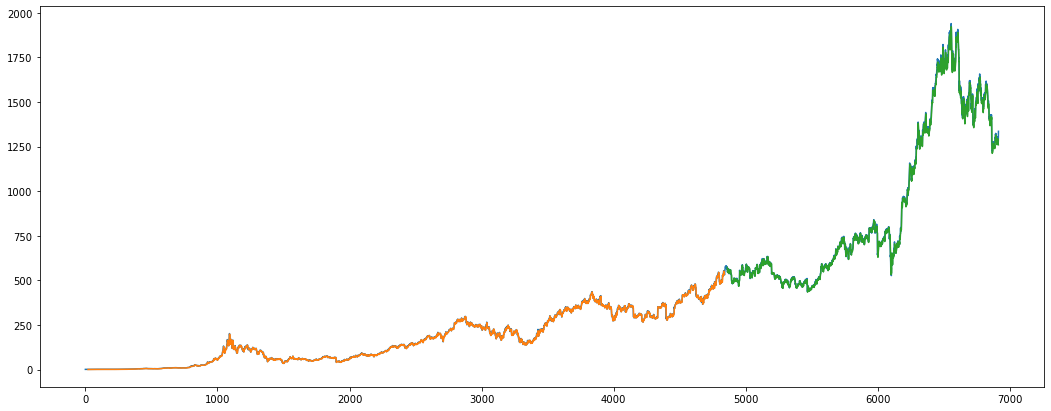

In [47]:
# shift train predictions for plotting
look_back=20
trainPredictPlot = numpy.empty_like(df1)  ## to take same shape and sata type of df1
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt1 = plt.figure(figsize=(18,7))
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [48]:
ytest

array([0.29292232, 0.28943425, 0.28201318, ..., 0.65209306, 0.65485257,
       0.65939164])

In [49]:
test_predict

array([[ 572.28735],
       [ 568.82886],
       [ 562.2681 ],
       ...,
       [1277.7408 ],
       [1259.8849 ],
       [1259.7994 ]], dtype=float32)

In [50]:
test_predict1 = test_predict.flatten()

In [51]:
len(ytest)

2054

In [52]:
test_predict1

array([ 572.28735,  568.82886,  562.2681 , ..., 1277.7408 , 1259.8849 ,
       1259.7994 ], dtype=float32)

In [53]:
ytest1 = ytest.flatten()

In [54]:
ytest1 = ytest1.reshape(1,-1)

In [55]:
ytest1

array([[0.29292232, 0.28943425, 0.28201318, ..., 0.65209306, 0.65485257,
        0.65939164]])

In [56]:
ytest2 = scaler.inverse_transform(ytest1)

In [57]:
ytest2

array([[ 568.66247559,  561.90002441,  547.51251221, ..., 1265.        ,
        1270.34997559, 1279.15002441]])

In [58]:
ytest2 = ytest2.flatten()

In [59]:
len(ytest2)

2054

In [64]:
df2 = df.iloc[4860:,:]

In [65]:
len(df2)

2054

In [66]:
df2.head()

,Open,Close
Date,,
2015-03-05,566.762512,561.900024
2015-03-09,564.750000,547.512512
2015-03-10,549.525024,549.500000
2015-03-11,548.525024,545.549988
2015-03-12,544.750000,554.575012


In [67]:
df2['predicted'] = test_predict1

In [68]:
df2.head(20)

,Open,Close,predicted
Date,,,
2015-03-05,566.762512,561.900024,572.287354
2015-03-09,564.750000,547.512512,568.828857
2015-03-10,549.525024,549.500000,562.268127
2015-03-11,548.525024,545.549988,549.283264
2015-03-12,544.750000,554.575012,546.579529
2015-03-13,556.250000,555.099976,543.670593
2015-03-16,552.637512,566.662476,549.949402
2015-03-17,566.662476,560.125000,553.022095
2015-03-18,563.625000,557.375000,562.549194


In [69]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2054 entries, 2015-03-05 to 2023-06-30
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2054 non-null   float64
 1   Close      2054 non-null   float64
 2   predicted  2054 non-null   float32
dtypes: float32(1), float64(2)
memory usage: 56.2 KB


In [70]:
df2.tail()

,Open,Close,predicted
Date,,,
2023-06-22,1289.400024,1281.550049,1293.622803
2023-06-23,1276.449951,1265.000000,1292.824585
2023-06-26,1270.250000,1270.349976,1277.740845
2023-06-27,1280.000000,1279.150024,1259.884888
2023-06-30,1308.199951,1335.500000,1259.799438


In [71]:
df2['temp_signal'] = df2['predicted'] - df2['Close']

In [72]:
df2.head()

,Open,Close,predicted,temp_signal
Date,,,,
2015-03-05,566.762512,561.900024,572.287354,10.387329
2015-03-09,564.750000,547.512512,568.828857,21.316345
2015-03-10,549.525024,549.500000,562.268127,12.768127
2015-03-11,548.525024,545.549988,549.283264,3.733276
2015-03-12,544.750000,554.575012,546.579529,-7.995483


In [73]:
df2['signal'] = df2['temp_signal'].apply(lambda x:1 if x>0 else 0)

In [74]:
df2.head()

,Open,Close,predicted,temp_signal,signal
Date,,,,,
2015-03-05,566.762512,561.900024,572.287354,10.387329,1
2015-03-09,564.750000,547.512512,568.828857,21.316345,1
2015-03-10,549.525024,549.500000,562.268127,12.768127,1
2015-03-11,548.525024,545.549988,549.283264,3.733276,1
2015-03-12,544.750000,554.575012,546.579529,-7.995483,0


In [75]:
df2.drop(columns='temp_signal',inplace = True)

In [76]:
df2.head()

,Open,Close,predicted,signal
Date,,,,
2015-03-05,566.762512,561.900024,572.287354,1
2015-03-09,564.750000,547.512512,568.828857,1
2015-03-10,549.525024,549.500000,562.268127,1
2015-03-11,548.525024,545.549988,549.283264,1
2015-03-12,544.750000,554.575012,546.579529,0


In [77]:
signal = list(df2['signal'])

In [78]:
signal

[1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,


In [79]:
signal.insert(0,999)

In [80]:
signal

[999,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1

In [81]:
len(df2)

2054

In [82]:
len(signal)

2055

In [83]:
signal.pop()

0

In [84]:
len(signal)

2054

In [85]:
new_signal = np.array(signal)

In [86]:
new_signal

array([999,   1,   1, ...,   1,   1,   0])

In [87]:
df2['new_signal'] = new_signal

In [88]:
df2.head()

,Open,Close,predicted,signal,new_signal
Date,,,,,
2015-03-05,566.762512,561.900024,572.287354,1,999
2015-03-09,564.750000,547.512512,568.828857,1,1
2015-03-10,549.525024,549.500000,562.268127,1,1
2015-03-11,548.525024,545.549988,549.283264,1,1
2015-03-12,544.750000,554.575012,546.579529,0,1


In [89]:
df2.drop(columns = 'signal',inplace = True)

In [90]:
df3 = df2[df2['new_signal']==1]

In [91]:
df3.head()

,Open,Close,predicted,new_signal
Date,,,,
2015-03-09,564.750000,547.512512,568.828857,1
2015-03-10,549.525024,549.500000,562.268127,1
2015-03-11,548.525024,545.549988,549.283264,1
2015-03-12,544.750000,554.575012,546.579529,1
2015-03-19,558.650024,557.612488,560.789612,1


In [92]:
df3['profit_loss'] = df3['Close'] - df3['Open']

In [93]:
df3.head()

,Open,Close,predicted,new_signal,profit_loss
Date,,,,,
2015-03-09,564.750000,547.512512,568.828857,1,-17.237488
2015-03-10,549.525024,549.500000,562.268127,1,-0.025024
2015-03-11,548.525024,545.549988,549.283264,1,-2.975037
2015-03-12,544.750000,554.575012,546.579529,1,9.825012
2015-03-19,558.650024,557.612488,560.789612,1,-1.037537


In [94]:
df3['profit_loss'].sum()

-47.11297607421875

In [95]:
df4 = df2[df2['new_signal']==0]

In [96]:
df4['profit_loss'] = df4['Open'] - df4['Close']

In [97]:
df4.head()

,Open,Close,predicted,new_signal,profit_loss
Date,,,,,
2015-03-13,556.250000,555.099976,543.670593,0,1.150024
2015-03-16,552.637512,566.662476,549.949402,0,-14.024963
2015-03-17,566.662476,560.125000,553.022095,0,6.537476
2015-03-18,563.625000,557.375000,562.549194,0,6.250000
2015-03-23,563.250000,558.362488,556.168945,0,4.887512


In [98]:
df2.head()

,Open,Close,predicted,new_signal
Date,,,,
2015-03-05,566.762512,561.900024,572.287354,999
2015-03-09,564.750000,547.512512,568.828857,1
2015-03-10,549.525024,549.500000,562.268127,1
2015-03-11,548.525024,545.549988,549.283264,1
2015-03-12,544.750000,554.575012,546.579529,1


In [99]:
df2.tail()

,Open,Close,predicted,new_signal
Date,,,,
2023-06-22,1289.400024,1281.550049,1293.622803,0
2023-06-23,1276.449951,1265.000000,1292.824585,1
2023-06-26,1270.250000,1270.349976,1277.740845,1
2023-06-27,1280.000000,1279.150024,1259.884888,1
2023-06-30,1308.199951,1335.500000,1259.799438,0


In [100]:
df4['profit_loss'].sum()

830.6231384277344

In [101]:
Total_profit = df4['profit_loss'].sum() + df3['profit_loss'].sum()

In [102]:
Total_profit

783.5101623535156

In [103]:
# check open price for first day and close price for last day
print("Starting price: ",df2.iloc[0][0])
print("Ending price: ", df2.iloc[-1][2])

Starting price:  566.7625122070312
Ending price:  1259.7994384765625


In [104]:
# total profit if buy and hold

buy_hold_profit = df2.iloc[-1][2] - df2.iloc[0][0]
buy_hold_profit

693.0369262695312

In [105]:
# excess profit generated by algo model

excess_profit = Total_profit - buy_hold_profit
excess_profit

90.47323608398438

In [108]:
# excess profit in percent

excess_profit_percent = (excess_profit *100)/Total_profit
excess_profit_percent

11.54716817101899

In [109]:
len(df3)

777

In [110]:
len(df4)

1276

In [111]:
len(df2)

2054